# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

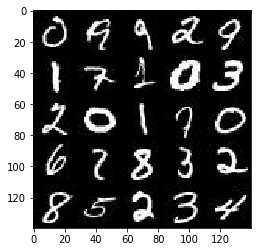

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

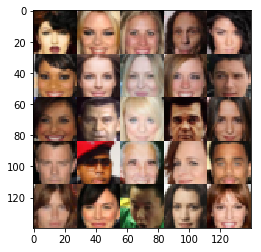

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())
    return (real_inputs, z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(inputs, alpha):
    return tf.maximum(inputs, alpha * inputs)

def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #28 x 28 x out_channel_dim images
    with tf.variable_scope('discriminator', reuse=reuse):
        layer0 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        layer0 = leaky_relu(layer0, alpha)
        
        layer1 = tf.layers.conv2d(layer0, 128, 5, 2, 'same')
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = leaky_relu(layer1, alpha)

        layer2 = tf.layers.conv2d(layer1, 256, 5, 2, 'same')
        layer2 = tf.layers.batch_normalization(layer1, training=True)
        layer2 = leaky_relu(layer2, alpha)

        layer3 = tf.layers.conv2d(layer2, 512, 5, 2, 'same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3, alpha)

        flat = tf.reshape(layer3, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 7 * 7 * 512)

        layer0 = tf.reshape(x, (-1, 7, 7, 512))
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = leaky_relu(layer0, alpha)

        layer1 = tf.layers.conv2d_transpose(layer0, 256, 5, 2, 'same')
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)

        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, 1, 'same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)

        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    d_loss = d_loss_real + d_loss_fake
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
PRINT_INTERVAL = 10
IMAGE_INTERVAL = 100
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    real_inputs, z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={real_inputs: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z, real_inputs: batch_images, lr: learning_rate})
                if step % PRINT_INTERVAL == 0:
                    train_loss_d = d_loss.eval({z: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if step % IMAGE_INTERVAL == 0:
                    show_generator_output(sess, 16, z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.cpkt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.4964
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 3.0900... Generator Loss: 0.0782
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 1.4236
Epoch 1/2... Discriminator Loss: 1.7146... Generator Loss: 0.2807
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 1.9181
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 1.6815
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 0.5742


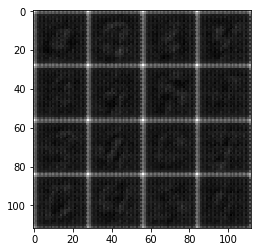

Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 1.2847
Epoch 1/2... Discriminator Loss: 0.2318... Generator Loss: 2.3805
Epoch 1/2... Discriminator Loss: 2.6203... Generator Loss: 8.0224
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 0.2686... Generator Loss: 2.1783


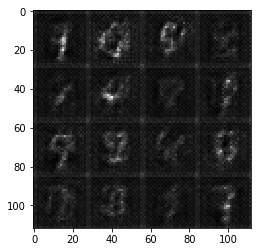

Epoch 1/2... Discriminator Loss: 0.1918... Generator Loss: 3.3786
Epoch 1/2... Discriminator Loss: 0.1555... Generator Loss: 2.9297
Epoch 1/2... Discriminator Loss: 0.1375... Generator Loss: 3.7059
Epoch 1/2... Discriminator Loss: 0.3282... Generator Loss: 1.5784
Epoch 1/2... Discriminator Loss: 0.0720... Generator Loss: 3.4088
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 0.7794... Generator Loss: 3.7713
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 3.2505
Epoch 1/2... Discriminator Loss: 0.2102... Generator Loss: 3.3678


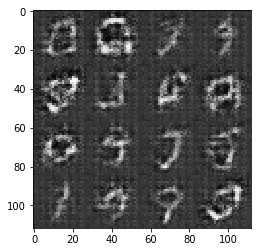

Epoch 1/2... Discriminator Loss: 0.2242... Generator Loss: 4.4204
Epoch 1/2... Discriminator Loss: 0.6893... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 0.2158... Generator Loss: 2.5307
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 1.6352
Epoch 1/2... Discriminator Loss: 4.9557... Generator Loss: 9.6664
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.0704
Epoch 1/2... Discriminator Loss: 0.6421... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 0.4163... Generator Loss: 1.9192
Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 0.2577... Generator Loss: 1.9264


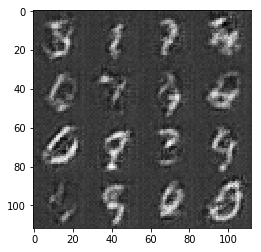

Epoch 1/2... Discriminator Loss: 0.2746... Generator Loss: 1.8875
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 4.1382
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 2.0876
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 0.1966... Generator Loss: 3.2914
Epoch 1/2... Discriminator Loss: 0.3080... Generator Loss: 1.7874
Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.0527


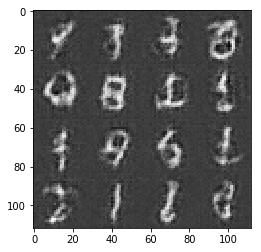

Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 2.9964
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.2802... Generator Loss: 2.7461
Epoch 1/2... Discriminator Loss: 0.2821... Generator Loss: 2.0300
Epoch 1/2... Discriminator Loss: 0.4316... Generator Loss: 1.4444
Epoch 1/2... Discriminator Loss: 0.2512... Generator Loss: 2.4808
Epoch 1/2... Discriminator Loss: 0.1160... Generator Loss: 2.8506
Epoch 1/2... Discriminator Loss: 0.6170... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 0.2213... Generator Loss: 2.0843


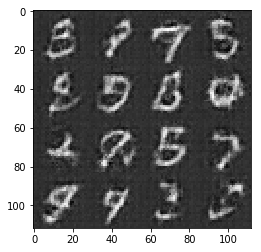

Epoch 1/2... Discriminator Loss: 0.1613... Generator Loss: 3.6908
Epoch 1/2... Discriminator Loss: 0.0424... Generator Loss: 4.9165
Epoch 1/2... Discriminator Loss: 2.5875... Generator Loss: 0.2247
Epoch 1/2... Discriminator Loss: 0.4465... Generator Loss: 2.3160
Epoch 1/2... Discriminator Loss: 0.7625... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 1.3545
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 1.2549
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 0.3728... Generator Loss: 1.6499
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 1.6847


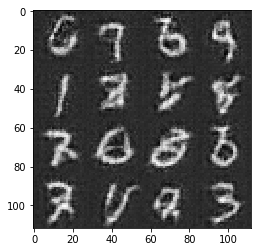

Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 1.4011
Epoch 1/2... Discriminator Loss: 0.2557... Generator Loss: 2.9449
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 1.4340
Epoch 1/2... Discriminator Loss: 0.7277... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 0.1067... Generator Loss: 3.0832
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 2.5314
Epoch 1/2... Discriminator Loss: 0.0623... Generator Loss: 3.9859
Epoch 1/2... Discriminator Loss: 0.1951... Generator Loss: 2.2108


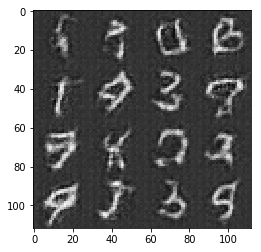

Epoch 1/2... Discriminator Loss: 0.2123... Generator Loss: 2.3134
Epoch 1/2... Discriminator Loss: 0.1360... Generator Loss: 2.9794
Epoch 1/2... Discriminator Loss: 0.0406... Generator Loss: 4.6500
Epoch 1/2... Discriminator Loss: 0.4400... Generator Loss: 1.4827
Epoch 1/2... Discriminator Loss: 3.0948... Generator Loss: 9.1100
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 2.2900
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 0.3583... Generator Loss: 1.6331


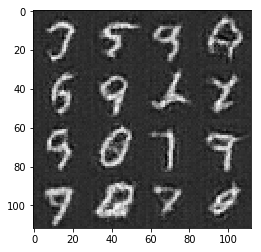

Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 1.2068
Epoch 1/2... Discriminator Loss: 0.1603... Generator Loss: 3.4570
Epoch 1/2... Discriminator Loss: 0.3419... Generator Loss: 1.6550
Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 1.7602
Epoch 2/2... Discriminator Loss: 0.1599... Generator Loss: 2.5998
Epoch 2/2... Discriminator Loss: 0.2054... Generator Loss: 2.3350
Epoch 2/2... Discriminator Loss: 0.2290... Generator Loss: 2.1816
Epoch 2/2... Discriminator Loss: 0.2797... Generator Loss: 1.9077
Epoch 2/2... Discriminator Loss: 0.0757... Generator Loss: 3.3579
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 3.1611


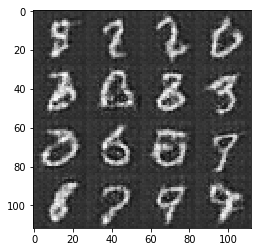

Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 1.1819
Epoch 2/2... Discriminator Loss: 0.4888... Generator Loss: 1.3318
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 0.2724... Generator Loss: 2.1868
Epoch 2/2... Discriminator Loss: 0.1465... Generator Loss: 2.6584
Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 5.6378
Epoch 2/2... Discriminator Loss: 0.3110... Generator Loss: 1.7960
Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 1.6241
Epoch 2/2... Discriminator Loss: 0.0734... Generator Loss: 3.9344
Epoch 2/2... Discriminator Loss: 0.1016... Generator Loss: 3.3618


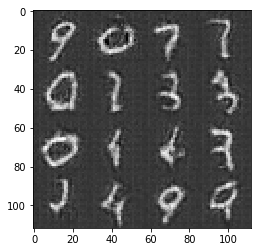

Epoch 2/2... Discriminator Loss: 0.1008... Generator Loss: 3.1486
Epoch 2/2... Discriminator Loss: 0.3912... Generator Loss: 1.5165
Epoch 2/2... Discriminator Loss: 0.1096... Generator Loss: 2.9773
Epoch 2/2... Discriminator Loss: 0.1098... Generator Loss: 2.8837
Epoch 2/2... Discriminator Loss: 0.1074... Generator Loss: 3.0910
Epoch 2/2... Discriminator Loss: 0.1097... Generator Loss: 2.8677
Epoch 2/2... Discriminator Loss: 0.0919... Generator Loss: 3.2312
Epoch 2/2... Discriminator Loss: 0.0741... Generator Loss: 3.3684
Epoch 2/2... Discriminator Loss: 2.0011... Generator Loss: 0.2853
Epoch 2/2... Discriminator Loss: 1.7412... Generator Loss: 0.5209


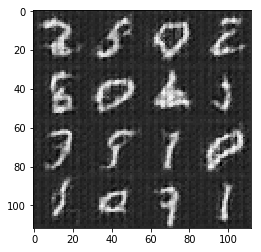

Epoch 2/2... Discriminator Loss: 0.3602... Generator Loss: 1.9328
Epoch 2/2... Discriminator Loss: 0.4621... Generator Loss: 2.0888
Epoch 2/2... Discriminator Loss: 0.4353... Generator Loss: 1.4943
Epoch 2/2... Discriminator Loss: 0.4107... Generator Loss: 1.4593
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 2.0626
Epoch 2/2... Discriminator Loss: 0.3201... Generator Loss: 1.6929
Epoch 2/2... Discriminator Loss: 0.2161... Generator Loss: 2.0256
Epoch 2/2... Discriminator Loss: 0.2252... Generator Loss: 2.1336
Epoch 2/2... Discriminator Loss: 0.3211... Generator Loss: 1.5921
Epoch 2/2... Discriminator Loss: 0.2465... Generator Loss: 1.8380


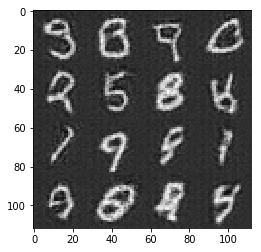

Epoch 2/2... Discriminator Loss: 0.1011... Generator Loss: 3.0565
Epoch 2/2... Discriminator Loss: 0.1474... Generator Loss: 2.5136
Epoch 2/2... Discriminator Loss: 0.0668... Generator Loss: 4.9882
Epoch 2/2... Discriminator Loss: 0.1359... Generator Loss: 2.7781
Epoch 2/2... Discriminator Loss: 0.2650... Generator Loss: 2.5277
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 0.1489... Generator Loss: 2.7387
Epoch 2/2... Discriminator Loss: 0.3720... Generator Loss: 1.5270
Epoch 2/2... Discriminator Loss: 0.0467... Generator Loss: 5.5973


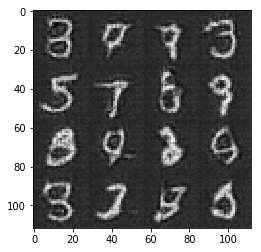

Epoch 2/2... Discriminator Loss: 0.0771... Generator Loss: 3.6949
Epoch 2/2... Discriminator Loss: 0.2202... Generator Loss: 2.0455
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 6.7633
Epoch 2/2... Discriminator Loss: 0.5228... Generator Loss: 3.0478
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 1.7420
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 1.5901
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 0.2665... Generator Loss: 2.1411
Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.0472


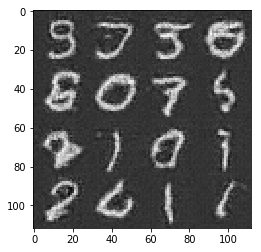

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 0.3124... Generator Loss: 1.6289
Epoch 2/2... Discriminator Loss: 0.2746... Generator Loss: 3.2568
Epoch 2/2... Discriminator Loss: 0.2740... Generator Loss: 1.7887
Epoch 2/2... Discriminator Loss: 0.2556... Generator Loss: 1.9750
Epoch 2/2... Discriminator Loss: 0.2768... Generator Loss: 1.9502
Epoch 2/2... Discriminator Loss: 0.3034... Generator Loss: 1.7400
Epoch 2/2... Discriminator Loss: 0.2841... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 0.1205... Generator Loss: 2.8470
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 0.9261


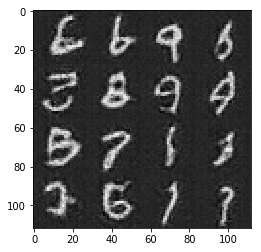

Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 1.9724
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 2.3394
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 1.7389
Epoch 2/2... Discriminator Loss: 0.2254... Generator Loss: 3.4906
Epoch 2/2... Discriminator Loss: 0.1466... Generator Loss: 2.7478
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 3.4376
Epoch 2/2... Discriminator Loss: 0.2233... Generator Loss: 2.1125
Epoch 2/2... Discriminator Loss: 0.0490... Generator Loss: 3.8800
Epoch 2/2... Discriminator Loss: 0.0947... Generator Loss: 3.1039


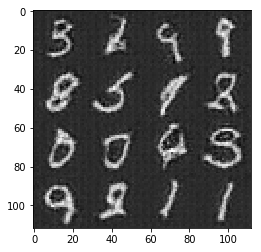

Epoch 2/2... Discriminator Loss: 0.3090... Generator Loss: 1.7024
Epoch 2/2... Discriminator Loss: 0.0812... Generator Loss: 3.6045
Epoch 2/2... Discriminator Loss: 0.2632... Generator Loss: 2.1701
Epoch 2/2... Discriminator Loss: 0.1719... Generator Loss: 2.3600
Epoch 2/2... Discriminator Loss: 0.0603... Generator Loss: 3.8671
Epoch 2/2... Discriminator Loss: 0.1168... Generator Loss: 4.5605
Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 5.1922
Epoch 2/2... Discriminator Loss: 0.2124... Generator Loss: 2.1663
Epoch 2/2... Discriminator Loss: 0.1707... Generator Loss: 2.6659
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 0.8829


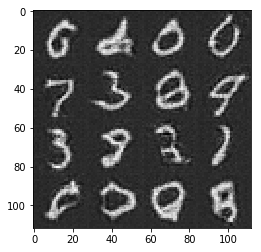

Epoch 2/2... Discriminator Loss: 3.6801... Generator Loss: 6.6022
Epoch 2/2... Discriminator Loss: 1.4713... Generator Loss: 4.1710
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 1.0323
Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 1.6893
Epoch 2/2... Discriminator Loss: 0.5132... Generator Loss: 2.1086
Epoch 2/2... Discriminator Loss: 0.3502... Generator Loss: 2.1007
Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.5767


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

# CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.8143... Generator Loss: 0.2616
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 12.3550
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 4.2719
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 2.0418
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.9312... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.4141


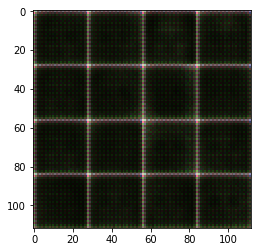

Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 5.8106
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 4.4194
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.3573
Epoch 1/1... Discriminator Loss: 2.1844... Generator Loss: 0.2397
Epoch 1/1... Discriminator Loss: 0.1543... Generator Loss: 3.3701
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 4.9782
Epoch 1/1... Discriminator Loss: 0.0519... Generator Loss: 6.5941
Epoch 1/1... Discriminator Loss: 2.2431... Generator Loss: 10.9944


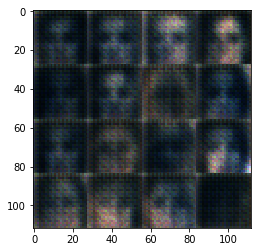

Epoch 1/1... Discriminator Loss: 0.1102... Generator Loss: 3.8810
Epoch 1/1... Discriminator Loss: 3.4948... Generator Loss: 10.8453
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 1.4435
Epoch 1/1... Discriminator Loss: 2.5933... Generator Loss: 0.1272
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 13.1169
Epoch 1/1... Discriminator Loss: 0.1318... Generator Loss: 5.0467
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.6983
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 11.0237
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 1.9741


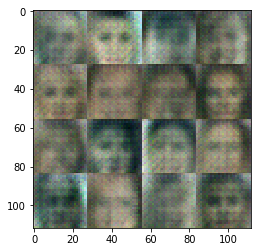

Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.4877
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 2.3939
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.3876


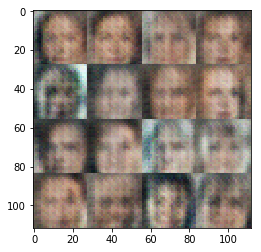

Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.2696... Generator Loss: 2.3405
Epoch 1/1... Discriminator Loss: 3.8789... Generator Loss: 4.7336
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 2.0361... Generator Loss: 2.8876
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 4.7950
Epoch 1/1... Discriminator Loss: 0.2405... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 0.1132... Generator Loss: 6.3347
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 3.3560


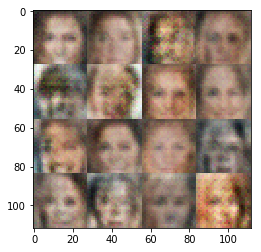

Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 6.9201
Epoch 1/1... Discriminator Loss: 0.1325... Generator Loss: 2.5890
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 1.4019
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 5.9572
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 4.5205
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 8.9698
Epoch 1/1... Discriminator Loss: 0.1166... Generator Loss: 2.6127


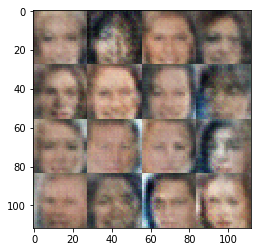

Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 6.6924
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 11.5728
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 4.4042
Epoch 1/1... Discriminator Loss: 0.5940... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.8863... Generator Loss: 13.2180
Epoch 1/1... Discriminator Loss: 0.0564... Generator Loss: 3.5030
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 2.3381
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 8.1119


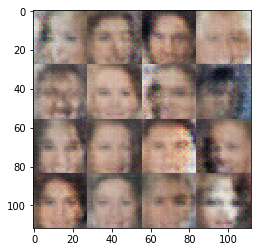

Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 9.3883
Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 2.4703
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 6.4345
Epoch 1/1... Discriminator Loss: 0.2077... Generator Loss: 8.6300
Epoch 1/1... Discriminator Loss: 0.2397... Generator Loss: 1.9775
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 8.6333
Epoch 1/1... Discriminator Loss: 0.0923... Generator Loss: 6.3628
Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 6.1917
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 4.2340


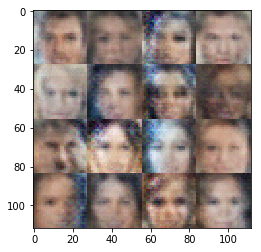

Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 7.9303
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 9.3335
Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 6.6624
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 8.4132
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 8.3814
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 4.1112
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 2.2855
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 1.1729


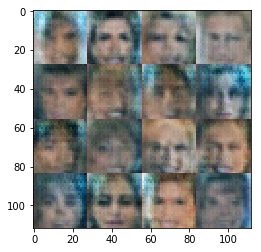

Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 6.2385
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 4.0611
Epoch 1/1... Discriminator Loss: 0.1299... Generator Loss: 7.5922
Epoch 1/1... Discriminator Loss: 2.8236... Generator Loss: 0.1032
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 5.8750
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 2.2967
Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 8.9773
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 6.7366
Epoch 1/1... Discriminator Loss: 0.0706... Generator Loss: 4.0677
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 2.4626


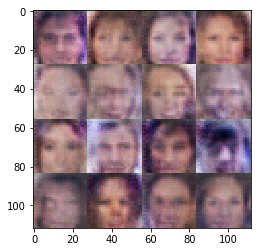

Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 6.6174
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 6.9356
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 10.8250
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 8.2844
Epoch 1/1... Discriminator Loss: 0.2213... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 6.8440
Epoch 1/1... Discriminator Loss: 0.0832... Generator Loss: 3.6108
Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 4.2646
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 9.1789
Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 6.1561


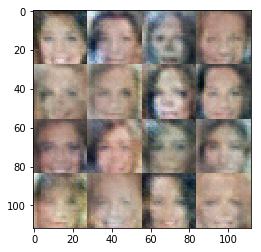

Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 2.6216
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 6.9076
Epoch 1/1... Discriminator Loss: 0.3227... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 3.5281
Epoch 1/1... Discriminator Loss: 0.0526... Generator Loss: 9.5366
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 11.8551
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 7.6123
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 13.9685
Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 14.0839
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 14.4885


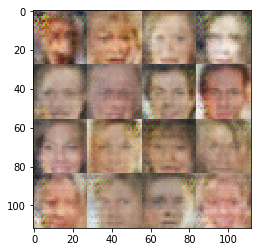

Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 5.9612
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 1.8392
Epoch 1/1... Discriminator Loss: 0.1367... Generator Loss: 2.7209
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 7.6303
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.3234
Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 8.8490
Epoch 1/1... Discriminator Loss: 0.1226... Generator Loss: 9.9897
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 5.5810
Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 10.8624


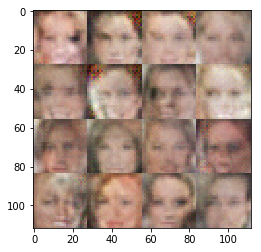

Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 15.1330
Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 5.1766
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 5.0759
Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 14.4901
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 8.6628
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 9.0286
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 5.4572
Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 4.5484
Epoch 1/1... Discriminator Loss: 0.0908... Generator Loss: 6.7207
Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 8.9518


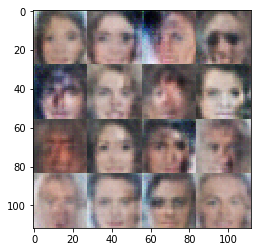

Epoch 1/1... Discriminator Loss: 2.3636... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 6.2357
Epoch 1/1... Discriminator Loss: 3.8857... Generator Loss: 9.9726
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 6.4408
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 4.7220
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 4.8611
Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 13.1651
Epoch 1/1... Discriminator Loss: 0.0857... Generator Loss: 3.3281
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 9.1078


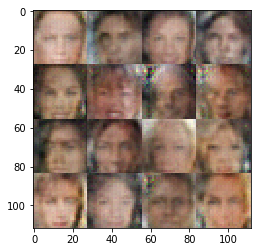

Epoch 1/1... Discriminator Loss: 0.2175... Generator Loss: 7.5923
Epoch 1/1... Discriminator Loss: 0.0517... Generator Loss: 7.5953
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 9.3355
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 7.1497
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 6.7116
Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 3.8977
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 9.9538
Epoch 1/1... Discriminator Loss: 2.4170... Generator Loss: 0.1746
Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 13.6801
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 6.5834


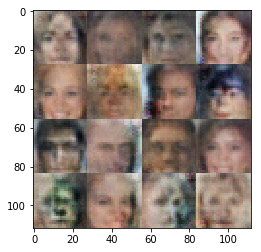

Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 1.9948
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 2.2150
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 2.0590
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 11.4241
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 10.3603
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 7.6472
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 2.7417
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 5.8159
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 6.4597
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 0.8887


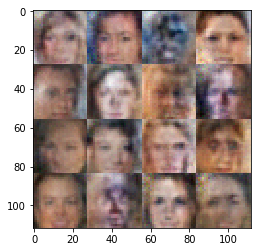

Epoch 1/1... Discriminator Loss: 0.3039... Generator Loss: 12.6865
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 3.4252
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 7.8879
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 1.5229
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 6.0847
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 13.5375
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 8.9685
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 2.2481
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 1.4749


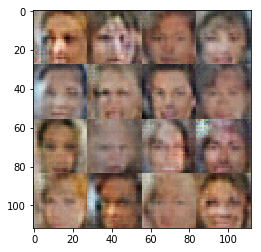

Epoch 1/1... Discriminator Loss: 0.3221... Generator Loss: 6.6681
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 2.1754... Generator Loss: 0.2734
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 3.5954
Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 4.7174
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 3.6309
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 1.5846


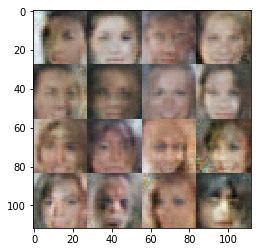

Epoch 1/1... Discriminator Loss: 0.1397... Generator Loss: 5.6623
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 10.3228
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 3.3139
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 3.8430
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 4.6169
Epoch 1/1... Discriminator Loss: 1.8010... Generator Loss: 0.2650
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 4.0463
Epoch 1/1... Discriminator Loss: 0.0584... Generator Loss: 5.3826
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 4.5973
Epoch 1/1... Discriminator Loss: 0.1327... Generator Loss: 3.3335


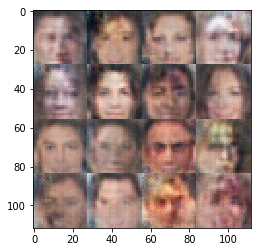

Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 2.0950
Epoch 1/1... Discriminator Loss: 0.0878... Generator Loss: 7.3694
Epoch 1/1... Discriminator Loss: 0.2943... Generator Loss: 2.1507
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 1.6792
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 7.6313
Epoch 1/1... Discriminator Loss: 3.4788... Generator Loss: 0.0593
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 7.3813
Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 3.5780
Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 3.4811
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 10.0027


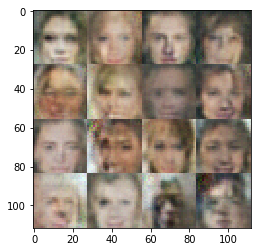

Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 1.9551
Epoch 1/1... Discriminator Loss: 0.1623... Generator Loss: 3.8078
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 6.0969
Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 3.8700
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 6.1026
Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 3.1086
Epoch 1/1... Discriminator Loss: 0.0382... Generator Loss: 5.2531
Epoch 1/1... Discriminator Loss: 0.1291... Generator Loss: 3.6292
Epoch 1/1... Discriminator Loss: 0.0929... Generator Loss: 4.0979
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 5.4672


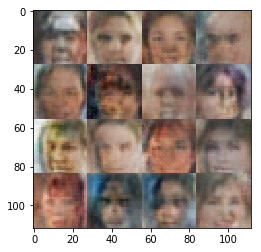

Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 1.3563
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 8.8292
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 3.2388
Epoch 1/1... Discriminator Loss: 2.5602... Generator Loss: 0.1477
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 0.2594... Generator Loss: 4.6446


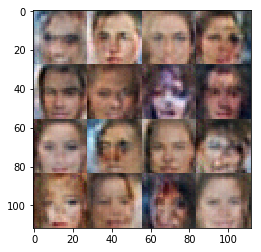

Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 1.4807
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.5786
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 1.4465
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 4.4798
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.4265
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 1.7869


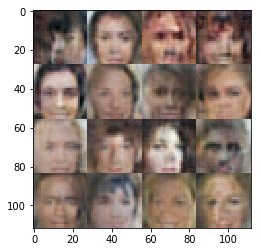

Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 3.1345
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 6.3174
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 1.8712
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 3.7341
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 2.1435
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 7.2506


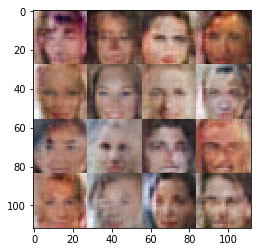

Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 1.7719
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 3.0281
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 0.3102... Generator Loss: 1.8910


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.